In [1]:
import networkx as nx
import random
import heapq
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
import pandas as pd

# import đồ thị email-Eu-core

In [4]:
# Đọc đồ thị từ file và gán xác suất ngẫu nhiên cho các cạnh
random.seed(6)
G = nx.DiGraph()

with open('data/email-Eu-core.txt', 'r') as file:
    for line in file:
        if line.startswith('#'):
            continue
        source, target = map(int, line.split())
        probability = random.random()  # Xác suất ngẫu nhiên giữa 0 và 1
        weight = random.random()
        G.add_edge(source, target, probability=probability, weight=weight)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

# Xác định các tập S và T từ các cạnh của đồ thị
S = set()
T = set()
for u, v in G.edges():
    S.add(u)
    T.add(v)

# print("Set S:", S)
# print("Set T:", T)

Number of nodes: 1005
Number of edges: 25571


In [5]:

# Lấy các giá trị xác suất từ các cạnh
probabilities = [G[u][v]['probability'] for u, v in G.edges()]
weights = [G[u][v]['weight'] for u, v in G.edges()]
# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)


# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)

    
print("Giá trị cạnh trung bình của đồ thị protein579138:", mean_probability)
print("Độ lệch chuẩn của của  đồ thị protein579138:", std_deviation)
print("Trọng số cạnh trung bình của đồ thị là:",mean_weight)




Giá trị cạnh trung bình của đồ thị protein579138: 0.49997592443758215
Độ lệch chuẩn của của  đồ thị protein579138: 0.28853840579632817
Trọng số cạnh trung bình của đồ thị là: 0.5008380616468823


In [2]:
def plot_graph(G):
    pos = nx.spring_layout(G)  # Tạo bố cục cho đồ thị
    edge_labels = nx.get_edge_attributes(G, 'probability')  # Lấy thuộc tính xác suất của các cạnh

    # Vẽ đồ thị
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='red', node_size=500, font_size=8, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)  # Hiển thị nhãn của các cạnh

    plt.title('Uncertain Graph Visualization')
    plt.show()
    
def plot_graph_v2(G):
    pos = nx.spring_layout(G)  # Tạo bố cục cho đồ thị

    # Lấy thuộc tính xác suất và trọng số của các cạnh
    edge_probabilities = nx.get_edge_attributes(G, 'probability')
    edge_weights = nx.get_edge_attributes(G, 'weight')

    # Kết hợp xác suất và trọng số vào nhãn cạnh
    edge_labels = {edge: f"{edge_weights[edge]:.2f}, {edge_probabilities[edge]:.2f}" for edge in G.edges()}

    # Vẽ đồ thị
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='red', node_size=200, font_size=8, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)  # Hiển thị nhãn của các cạnh

    plt.title('Uncertain Weighted Directed Graph Visualization')
    plt.show()
    
def average_edge_probability(G):
    """ Tính xác suất trung bình của các cạnh trong đồ thị G. """
    total_probability = sum(nx.get_edge_attributes(G, 'probability').values())
    num_edges = G.number_of_edges()
    return total_probability / num_edges if num_edges > 0 else 0


def calculate_f_beta(G_S, beta):
    """
    Tính giá trị f_beta cho đồ thị con G_S.
    - G_S: Đồ thị con được kích thích từ tập hợp các đỉnh S.
    - beta: Ngưỡng xác suất β.
    """
    # Tính xác suất trung bình của cạnh trong G_S
    p_GS = average_edge_probability(G_S)
    
    # Số đỉnh và số cạnh của G_S
    num_vertices = G_S.number_of_nodes()
    num_edges = G_S.number_of_edges()
    
    # Tính f_beta dựa trên công thức
    f_beta = (p_GS - beta) * (num_edges / num_vertices if num_vertices > 0 else 0)
    return f_beta

def calculate_f_beta_v2(G_S, beta, S, T):
    # Tính xác suất trung bình của các cạnh trong G_S
    total_weighted = sum(G_S[u][v]['weight'] for u, v in G_S.edges())
    num_edges = G_S.number_of_edges()
    trong_so_trung_binh_canh = total_weighted / num_edges if num_edges > 0 else 0
    tong_trong_so_xac_xuat = sum(G_S[u][v]['weight'] * G_S[u][v]['probability'] for u, v in G_S.edges())
    p_GS = average_edge_probability(G_S)
    
    if len(S) > 0 and len(T) > 0:
        f_beta = (p_GS * trong_so_trung_binh_canh - beta) * (num_edges / (len(S) * len(T))**0.5)
    else:
        f_beta = 0
    return f_beta
    

def average_edge_probability_v2(G):
    """Tính xác suất trung bình của các cạnh trong đồ thị G."""
    total_probability = sum(nx.get_edge_attributes(G, 'probability').values())
    num_edges = G.number_of_edges()
    return total_probability / num_edges if num_edges > 0 else 0



def surplus_degree(G, v, beta):
    """
    Tính Surplus Degree của đỉnh v trong đồ thị G không sử dụng giá trị tuyệt đối.
    
    - G: đồ thị (V, E, p) với xác suất trên mỗi cạnh.
    - v: đỉnh cần tính Surplus Degree.
    - beta: tham số beta trong khoảng (0, 1).
    """
    # Lấy tập các cạnh liên kết với đỉnh v
    edges = G.edges(v, data=True)
    
    # Tính Surplus Degree
    s_deg = sum(edge[2]['probability'] - beta for edge in edges)
    
    return s_deg

def surplus_degree_v2(G, v, beta):
    """
    Tính Surplus Degree của đỉnh v trong đồ thị G có trọng số và xác suất.
    
    - G: đồ thị (V, E, p) với trọng số và xác suất trên mỗi cạnh.
    - v: đỉnh cần tính Surplus Degree.
    - beta: tham số beta trong khoảng (0, 1).
    """
    # Lấy các cạnh đi vào và đi ra từ đỉnh v
    in_edges = G.in_edges(v, data=True)
    out_edges = G.out_edges(v, data=True)
    
    # Tính Surplus Degree
    s_deg_in = sum(edge[2]['weight'] * edge[2]['probability'] - edge[2]['weight'] * beta for edge in in_edges)
    s_deg_out = sum(edge[2]['weight'] * edge[2]['probability'] - edge[2]['weight'] * beta for edge in out_edges)
    
    return s_deg_in + s_deg_out


def surplus_degree_out(G, v, beta):
    return sum(G[v][w]['weight'] *G[v][w]['probability'] - beta for w in G.successors(v) if w in G)

def surplus_degree_in(G, v, beta):
    return sum(G[u][v]['weight'] *G[u][v]['probability'] - beta for u in G.predecessors(v) if u in G)


def initialize_priority_queue_out(G, beta):
    """ Khởi tạo hàng đợi ưu tiên với bậc dư thừa cho mỗi đỉnh """
    priority_queue = []
    for v in G.nodes():
        sd = surplus_degree_out(G, v, beta)
        heapq.heappush(priority_queue, (sd, v))
        
    return priority_queue

def initialize_priority_queue_in(G, beta):
    """ Khởi tạo hàng đợi ưu tiên với bậc dư thừa cho mỗi đỉnh """
    priority_queue = []
    for v in G.nodes():
        sd = surplus_degree_in(G, v, beta)
        heapq.heappush(priority_queue, (sd, v))
        
    return priority_queue

def calculate_edge_density_v2(G):
    """
    Tính mật độ cạnh kỳ vọng của đồ thị G.
    """
    # Assuming the function `average_edge_probability` is defined elsewhere
    average_edge = average_edge_probability(G)
    num_edges = G.number_of_edges()
    
    num_vertices = G.number_of_nodes()  # Assuming num_vertices should be the number of nodes in G
#     num_possible_edges = num_vertices * (num_vertices - 1) / 2 
    num_possible_edges = num_vertices * (num_vertices - 1)
    return (average_edge * num_edges) / num_possible_edges

def calculate_edge_density(G):
    """ Tính mật độ cạnh kỳ vọng của đồ thị G. τ """
    num_vertices = len(G.nodes())
    num_possible_edges = num_vertices * (num_vertices - 1)
    sum_probabilities = sum(G[u][v]['probability'] for u, v in G.edges())
    print("sum_probabilities",sum_probabilities)
    print("num_possible_edges", num_possible_edges)
    return sum_probabilities / num_possible_edges

def calculate_edge_density_v3(G):
    """Tính mật độ cạnh kỳ vọng của đồ thị G. τ"""
    num_vertices = len(G.nodes())
    num_possible_edges = num_vertices * (num_vertices - 1) if num_vertices > 1 else 1
    sum_weighted_probabilities = sum(G[u][v]['weight'] * G[u][v]['probability'] for u, v in G.edges())
    return sum_weighted_probabilities / num_possible_edges

def expected_density(G):
    if G.number_of_edges() == 0:
        return 0
    probability_sum = sum(G[u][v]['probability'] for u, v in G.edges())
    num_vertices = len(G.nodes())
    return probability_sum /  num_vertices   if num_vertices > 0 else 0

def expected_density_v2(G):
    if G.number_of_edges() == 0:
        return 0
    probability_sum = sum(G[u][v]['probability'] for u, v in G.edges())
    num_vertices = len(G.nodes())
    return probability_sum /  (num_vertices*(num_vertices -1))   if num_vertices > 0 else 0

def greedy_average_surplus_degree(G, beta):
    H = G.copy()
    S_temp = set(H.nodes())
    T_temp = set(H.nodes())
    best_subgraph = H.copy()
    best_f_beta = calculate_f_beta_v2(best_subgraph, beta, S_temp, T_temp)

    priority_queue_out = initialize_priority_queue_out(H, beta)
    priority_queue_in = initialize_priority_queue_in(H, beta)

    with tqdm(total=H.number_of_nodes() - 2, desc="Processing", unit="node") as pbar:
        while S_temp and T_temp:
            while priority_queue_out:
                _, i_min = heapq.heappop(priority_queue_out)
                if i_min in H:
                    break

            while priority_queue_in:
                _, j_min = heapq.heappop(priority_queue_in)
                if j_min in H:
                    break

            d_S = surplus_degree_out(H, i_min, beta) if i_min in H else float('inf')
            d_T = surplus_degree_in(H, j_min, beta) if j_min in H else float('inf')
            
            if d_S <= d_T:
                S_temp.remove(i_min)
                H.remove_node(i_min)
            else:
                T_temp.remove(j_min)
                H.remove_node(j_min)

            current_f_beta = calculate_f_beta_v2(H, beta, S_temp, T_temp)
            
            S_temp = {u for u in S_temp if u in H}
            T_temp = {v for v in T_temp if v in H}
            
            if current_f_beta > best_f_beta:
                best_f_beta = current_f_beta
                best_subgraph = H.copy()  # Lưu bản sao của H với mật độ cao nhất

            # Cập nhật lại hàng đợi ưu tiên
            priority_queue_out = initialize_priority_queue_out(H, beta)
            priority_queue_in = initialize_priority_queue_in(H, beta)
            
            pbar.update(1)  # Cập nhật tiến trình mỗi khi một đỉnh được loại bỏ
    
    return best_subgraph


## Khi beta bằng 0.1

In [55]:
beta = 0.1

ObsEmailEuCore01 = greedy_average_surplus_degree(G,beta)


# Lấy các giá trị xác suất từ các cạnh
probabilities = [ObsEmailEuCore01[u][v]['probability'] for u, v in ObsEmailEuCore01.edges()]
weights = [ObsEmailEuCore01[u][v]['weight'] for u, v in ObsEmailEuCore01.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(ObsEmailEuCore01))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore01.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore01.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(ObsEmailEuCore01))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(ObsEmailEuCore01))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)

100%|██████████████████████████████████████████████████████████████████████████████| 1003/1003 [00:46<00:00, 21.40it/s]

Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là: 22.90862654359603
Số đỉnh trong đồ thị con của thuật toán obs  là: 208
Số cạnh trong đồ thị con của thuật toán obs  là: 9414
sum_probabilities 4764.994321067974
num_possible_edges 43056
Mật độ kì cạnh vọng của thuật toán obs  là: 0.11066969344732382
Xác xuất cạnh trung bình của thuật toán obs là: 0.5061604335105134
 trọng số cạnh trung bình của thuật toán obs là: 0.4975614166564639
Độ lệch chuẩn của thuật toán obs: 0.2894176798873584


## Khi beta = 0.2

In [48]:
beta = 0.2

ObsEmailEuCore02 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [ObsEmailEuCore02[u][v]['probability'] for u, v in ObsEmailEuCore02.edges()]
weights = [ObsEmailEuCore02[u][v]['weight'] for u, v in ObsEmailEuCore02.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(ObsEmailEuCore02))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore02.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore02.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(ObsEmailEuCore02))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(ObsEmailEuCore02))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


Processing: 1005node [02:45,  6.06node/s]                                                                              

Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là: 17.87502077673858
Số đỉnh trong đồ thị con của thuật toán obs  là: 257
Số cạnh trong đồ thị con của thuật toán obs  là: 8777
sum_probabilities 4593.880339621815
num_possible_edges 65792
Mật độ kì cạnh vọng của thuật toán obs  là: 0.06982429990913508
Xác xuất cạnh trung bình của thuật toán obs là: 0.5233998336130586
 trọng số cạnh trung bình của thuật toán obs là: 0.5196830631076178
Độ lệch chuẩn của thuật toán obs: 0.28822867961085485


In [49]:
beta = 0.35

ObsEmailEuCore02 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [ObsEmailEuCore02[u][v]['probability'] for u, v in ObsEmailEuCore02.edges()]
weights = [ObsEmailEuCore02[u][v]['weight'] for u, v in ObsEmailEuCore02.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(ObsEmailEuCore02))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore02.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore02.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(ObsEmailEuCore02))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(ObsEmailEuCore02))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


Processing: 1005node [00:53, 18.80node/s]                                                                              

Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là: 1.7194434124807219
Số đỉnh trong đồ thị con của thuật toán obs  là: 2
Số cạnh trong đồ thị con của thuật toán obs  là: 4
sum_probabilities 3.4388868249614437
num_possible_edges 2
Mật độ kì cạnh vọng của thuật toán obs  là: 1.7194434124807219
Xác xuất cạnh trung bình của thuật toán obs là: 0.8597217062403609
 trọng số cạnh trung bình của thuật toán obs là: 0.8242070966595273
Độ lệch chuẩn của thuật toán obs: 0.11836408907047516


In [50]:
beta = 0.3

ObsEmailEuCore02 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [ObsEmailEuCore02[u][v]['probability'] for u, v in ObsEmailEuCore02.edges()]
weights = [ObsEmailEuCore02[u][v]['weight'] for u, v in ObsEmailEuCore02.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(ObsEmailEuCore02))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore02.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore02.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(ObsEmailEuCore02))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(ObsEmailEuCore02))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


Processing: 1005node [01:00, 16.75node/s]                                                                              

Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là: 1.7194434124807219
Số đỉnh trong đồ thị con của thuật toán obs  là: 2
Số cạnh trong đồ thị con của thuật toán obs  là: 4
sum_probabilities 3.4388868249614437
num_possible_edges 2
Mật độ kì cạnh vọng của thuật toán obs  là: 1.7194434124807219
Xác xuất cạnh trung bình của thuật toán obs là: 0.8597217062403609
 trọng số cạnh trung bình của thuật toán obs là: 0.8242070966595273
Độ lệch chuẩn của thuật toán obs: 0.11836408907047516


In [52]:
beta = 0.27

ObsEmailEuCore02 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [ObsEmailEuCore02[u][v]['probability'] for u, v in ObsEmailEuCore02.edges()]
weights = [ObsEmailEuCore02[u][v]['weight'] for u, v in ObsEmailEuCore02.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(ObsEmailEuCore02))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore02.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore02.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(ObsEmailEuCore02))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(ObsEmailEuCore02))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


Processing: 1005node [00:56, 17.83node/s]                                                                              

Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là: 1.846316835197146
Số đỉnh trong đồ thị con của thuật toán obs  là: 11
Số cạnh trong đồ thị con của thuật toán obs  là: 27
sum_probabilities 20.309485187168605
num_possible_edges 110
Mật độ kì cạnh vọng của thuật toán obs  là: 0.1846316835197146
Xác xuất cạnh trung bình của thuật toán obs là: 0.7522031550803187
 trọng số cạnh trung bình của thuật toán obs là: 0.7987990217032347
Độ lệch chuẩn của thuật toán obs: 0.22095945463705174


In [55]:
beta = 0.275

ObsEmailEuCore02 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [ObsEmailEuCore02[u][v]['probability'] for u, v in ObsEmailEuCore02.edges()]
weights = [ObsEmailEuCore02[u][v]['weight'] for u, v in ObsEmailEuCore02.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(ObsEmailEuCore02))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore02.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore02.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(ObsEmailEuCore02))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(ObsEmailEuCore02))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


Processing: 1005node [01:13, 13.64node/s]                                                                              

Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là: 1.6984677061922553
Số đỉnh trong đồ thị con của thuật toán obs  là: 11
Số cạnh trong đồ thị con của thuật toán obs  là: 23
sum_probabilities 18.683144768114808
num_possible_edges 110
Mật độ kì cạnh vọng của thuật toán obs  là: 0.1698467706192255
Xác xuất cạnh trung bình của thuật toán obs là: 0.8123106420919481
 trọng số cạnh trung bình của thuật toán obs là: 0.7793510082919212
Độ lệch chuẩn của thuật toán obs: 0.17931882322281406


In [ ]:
beta = 0.277 

ObsEmailEuCore02 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [ObsEmailEuCore02[u][v]['probability'] for u, v in ObsEmailEuCore02.edges()]
weights = [ObsEmailEuCore02[u][v]['weight'] for u, v in ObsEmailEuCore02.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(ObsEmailEuCore02))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore02.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore02.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(ObsEmailEuCore02))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(ObsEmailEuCore02))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


Processing:  15%|█████████▋                                                       | 150/1003 [00:30<02:09,  6.57node/s]

In [53]:
beta = 0.28

ObsEmailEuCore02 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [ObsEmailEuCore02[u][v]['probability'] for u, v in ObsEmailEuCore02.edges()]
weights = [ObsEmailEuCore02[u][v]['weight'] for u, v in ObsEmailEuCore02.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(ObsEmailEuCore02))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore02.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore02.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(ObsEmailEuCore02))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(ObsEmailEuCore02))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


Processing: 1005node [00:58, 17.17node/s]                                                                              

Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là: 1.7194434124807219
Số đỉnh trong đồ thị con của thuật toán obs  là: 2
Số cạnh trong đồ thị con của thuật toán obs  là: 4
sum_probabilities 3.4388868249614437
num_possible_edges 2
Mật độ kì cạnh vọng của thuật toán obs  là: 1.7194434124807219
Xác xuất cạnh trung bình của thuật toán obs là: 0.8597217062403609
 trọng số cạnh trung bình của thuật toán obs là: 0.8242070966595273
Độ lệch chuẩn của thuật toán obs: 0.11836408907047516


In [54]:
beta = 0.29

ObsEmailEuCore02 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [ObsEmailEuCore02[u][v]['probability'] for u, v in ObsEmailEuCore02.edges()]
weights = [ObsEmailEuCore02[u][v]['weight'] for u, v in ObsEmailEuCore02.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(ObsEmailEuCore02))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore02.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore02.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(ObsEmailEuCore02))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(ObsEmailEuCore02))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


Processing: 1005node [01:03, 15.90node/s]                                                                              

Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là: 1.7194434124807219
Số đỉnh trong đồ thị con của thuật toán obs  là: 2
Số cạnh trong đồ thị con của thuật toán obs  là: 4
sum_probabilities 3.4388868249614437
num_possible_edges 2
Mật độ kì cạnh vọng của thuật toán obs  là: 1.7194434124807219
Xác xuất cạnh trung bình của thuật toán obs là: 0.8597217062403609
 trọng số cạnh trung bình của thuật toán obs là: 0.8242070966595273
Độ lệch chuẩn của thuật toán obs: 0.11836408907047516


In [51]:
beta = 0.25

ObsEmailEuCore02 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [ObsEmailEuCore02[u][v]['probability'] for u, v in ObsEmailEuCore02.edges()]
weights = [ObsEmailEuCore02[u][v]['weight'] for u, v in ObsEmailEuCore02.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(ObsEmailEuCore02))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore02.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore02.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(ObsEmailEuCore02))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(ObsEmailEuCore02))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


Processing: 1005node [01:36, 10.41node/s]                                                                              

Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là: 5.24628135701621
Số đỉnh trong đồ thị con của thuật toán obs  là: 92
Số cạnh trong đồ thị con của thuật toán obs  là: 822
sum_probabilities 482.6578848454913
num_possible_edges 8372
Mật độ kì cạnh vọng của thuật toán obs  là: 0.057651443483694616
Xác xuất cạnh trung bình của thuật toán obs là: 0.5871750423911086
 trọng số cạnh trung bình của thuật toán obs là: 0.6031150377141511
Độ lệch chuẩn của thuật toán obs: 0.28855593655170775


## Khi beta = 0.4

In [29]:
beta = 0.4

ObsEmailEuCore04 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [ObsEmailEuCore04[u][v]['probability'] for u, v in ObsEmailEuCore04.edges()]
weights = [ObsEmailEuCore04[u][v]['weight'] for u, v in ObsEmailEuCore04.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(ObsEmailEuCore04))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore04.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore04.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(ObsEmailEuCore04))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(ObsEmailEuCore04))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


Processing: 1005node [00:43, 23.19node/s]                                                                              

Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là: 1.3362078994078095
Số đỉnh trong đồ thị con của thuật toán obs  là: 4
Số cạnh trong đồ thị con của thuật toán obs  là: 6
sum_probabilities 5.344831597631238
num_possible_edges 12
Mật độ kì cạnh vọng của thuật toán obs  là: 0.4454026331359365
Xác xuất cạnh trung bình của thuật toán obs là: 0.890805266271873
 trọng số cạnh trung bình của thuật toán obs là: 0.8552832962351243
Độ lệch chuẩn của thuật toán obs: 0.10629224646257118


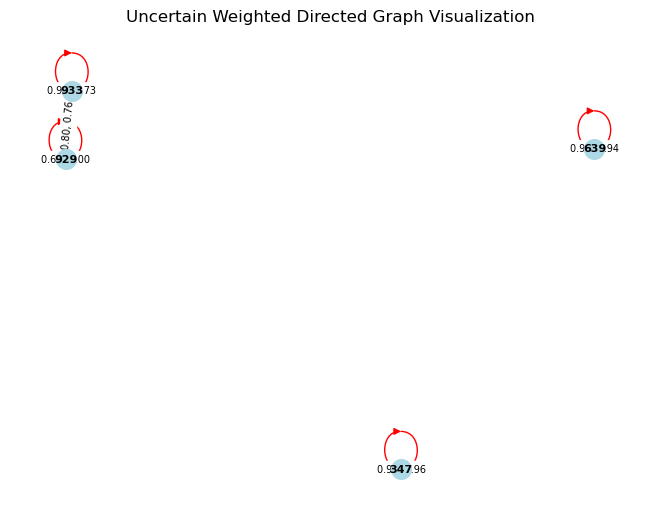

In [30]:
plot_graph_v2(ObsEmailEuCore04)

## Khi beta = 0.6

In [34]:
beta = 0.6

ObsEmailEuCore06 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [ObsEmailEuCore06[u][v]['probability'] for u, v in ObsEmailEuCore06.edges()]
weights = [ObsEmailEuCore06[u][v]['weight'] for u, v in ObsEmailEuCore06.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
# print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(ObsEmailEuCore06))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore06.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore06.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(ObsEmailEuCore06))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(ObsEmailEuCore06))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


Processing: 1005node [00:40, 24.79node/s]                                                                              

Số đỉnh trong đồ thị con của thuật toán obs  là: 2
Số cạnh trong đồ thị con của thuật toán obs  là: 4
sum_probabilities 3.4100459837663717
num_possible_edges 2
Mật độ kì cạnh vọng của thuật toán obs  là: 1.7050229918831858
Xác xuất cạnh trung bình của thuật toán obs là: 0.8525114959415929
 trọng số cạnh trung bình của thuật toán obs là: 0.3933528955779124
Độ lệch chuẩn của thuật toán obs: 0.07783985821730238


In [25]:
# Lưu đồ thị
nx.write_gexf(ObsEmailEuCore06, "ObsEmailEuCore06.gexf")


## Khi beta = 0.8

In [60]:
beta = 0.8

ObsEmailEuCore08 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [ObsEmailEuCore08[u][v]['probability'] for u, v in ObsEmailEuCore08.edges()]
weights = [ObsEmailEuCore08[u][v]['weight'] for u, v in ObsEmailEuCore08.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(ObsEmailEuCore08))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore08.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", ObsEmailEuCore08.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(ObsEmailEuCore08))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(ObsEmailEuCore08))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


100%|██████████████████████████████████████████████████████████████████████████████| 1003/1003 [00:13<00:00, 76.22it/s]

Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là: 1.2044068968402208
Số đỉnh trong đồ thị con của thuật toán obs  là: 4
Số cạnh trong đồ thị con của thuật toán obs  là: 5
sum_probabilities 4.817627587360883
num_possible_edges 12
Mật độ kì cạnh vọng của thuật toán obs  là: 0.40146896561340695
Xác xuất cạnh trung bình của thuật toán obs là: 0.9635255174721766
 trọng số cạnh trung bình của thuật toán obs là: 0.4395060410096788
Độ lệch chuẩn của thuật toán obs: 0.04959977923460279


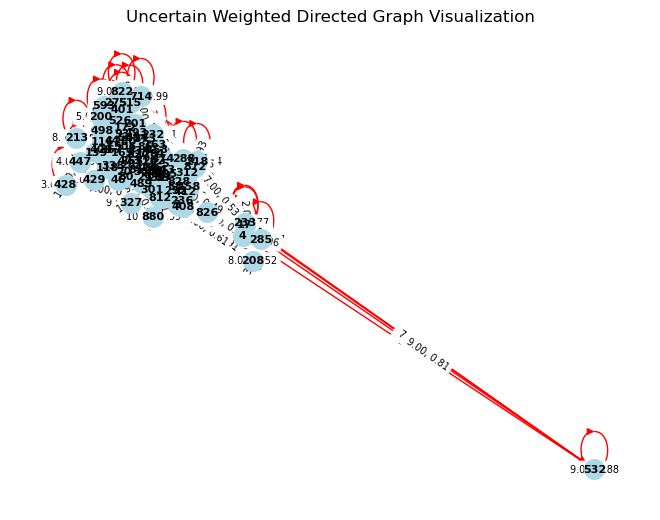

In [63]:
plot_graph_v2(obs_06)

# Đối với đồ thị protein 1736402.protein.links



In [3]:
random.seed(9)

# Đọc dữ liệu từ tệp TXT
file_path = 'data/1736402.protein.links.v12.0.txt'
data = pd.read_csv(file_path, sep=' ')

# Khởi tạo đồ thị có hướng
G = nx.DiGraph()

# Thêm các cạnh với trọng số và xác suất
for _, row in data.iterrows():
    protein1 = row['protein1']
    protein2 = row['protein2']
    combined_score = row['combined_score']
    
    # Giả sử xác suất được tính dựa trên combined_score
    probability = combined_score / 1000.0  # Điều chỉnh hệ số nếu cần thiết

     # Định hướng cạnh dựa trên một quy tắc ngẫu nhiên
    if random.choice([True, False]):
        G.add_edge(protein1, protein2, probability= probability, weight=random.random())
#     else:
#         G.add_edge(protein2, protein1, probability= probability, weight=random.randint(1, 10))

# # Hàm vẽ đồ thị
# def plot_graph(G):
#     pos = nx.spring_layout(G)  # Tạo bố cục cho đồ thị

#     # Lấy thuộc tính xác suất và trọng số của các cạnh
#     edge_probabilities = nx.get_edge_attributes(G, 'probability')
#     edge_weights = nx.get_edge_attributes(G, 'weight')

#     # Kết hợp xác suất và trọng số vào nhãn cạnh
#     edge_labels = {edge: f"{edge_weights[edge]:.2f}, {edge_probabilities[edge]:.2f}" for edge in G.edges()}

#     # Vẽ đồ thị
#     nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='red', node_size=500, font_size=8, font_weight='bold')
#     nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)  # Hiển thị nhãn của các cạnh

#     plt.title('Uncertain Weighted Directed Graph Visualization')
#     plt.show()

# # Gọi hàm để vẽ đồ thị
# plot_graph(G)

# # In các cạnh của đồ thị có hướng
# print("Edges in directed graph:")
# for edge in G.edges(data=True):
#     print(edge)
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())



# Lấy các giá trị xác suất từ các cạnh
probabilities = [G[u][v]['probability'] for u, v in G.edges()]
weights = [G[u][v]['weight'] for u, v in G.edges()]
# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)


# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
do_lech_chuan_trong_so = np.std(weights)

    
print("Giá trị cạnh trung bình của đồ thị protein579138:", mean_probability)
print("Độ lệch chuẩn của của  đồ thị protein579138:", std_deviation)
print("Độ lệch chuẩn trọng số của đồ thị con được tạo ra bởi thuật toán uds là:", do_lech_chuan_trong_so)
print("Trọng số cạnh trung bình của đồ thị là:",mean_weight)
print("Mật độ kì cạnh vọng là:",calculate_edge_density(G))




Number of nodes: 3082
Number of edges: 315247
Giá trị cạnh trung bình của đồ thị protein579138: 0.2812061907012597
Độ lệch chuẩn của của  đồ thị protein579138: 0.18194945319649977
Độ lệch chuẩn trọng số của đồ thị con được tạo ra bởi thuật toán uds là: 0.28855910003547514
Trọng số cạnh trung bình của đồ thị là: 0.49985353210339717
sum_probabilities 88649.408
num_possible_edges 9495642
Mật độ kì cạnh vọng là: 0.009335799306671418


In [4]:
total_weighted = sum(G[u][v]['weight'] for u, v in G.edges())
num_edges = G.number_of_edges()
trong_so_trung_binh_canh = total_weighted / num_edges if num_edges > 0 else 0
print(trong_so_trung_binh_canh)

0.49985353210339717


In [5]:
beta = 0.1

Obs511145Protein06 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs511145Protein06[u][v]['probability'] for u, v in Obs511145Protein06.edges()]
weights = [Obs511145Protein06[u][v]['weight'] for u, v in Obs511145Protein06.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
# print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs511145Protein06))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs511145Protein06))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs511145Protein06))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)
beta = 0.2

Obs511145Protein06 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs511145Protein06[u][v]['probability'] for u, v in Obs511145Protein06.edges()]
weights = [Obs511145Protein06[u][v]['weight'] for u, v in Obs511145Protein06.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
# print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs511145Protein06))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs511145Protein06))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs511145Protein06))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)
beta = 0.3

Obs511145Protein06 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs511145Protein06[u][v]['probability'] for u, v in Obs511145Protein06.edges()]
weights = [Obs511145Protein06[u][v]['weight'] for u, v in Obs511145Protein06.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
# print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs511145Protein06))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs511145Protein06))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs511145Protein06))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)
beta = 0.4

Obs511145Protein06 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs511145Protein06[u][v]['probability'] for u, v in Obs511145Protein06.edges()]
weights = [Obs511145Protein06[u][v]['weight'] for u, v in Obs511145Protein06.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
# print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs511145Protein06))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs511145Protein06))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs511145Protein06))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)
beta = 0.5 

Obs511145Protein06 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs511145Protein06[u][v]['probability'] for u, v in Obs511145Protein06.edges()]
weights = [Obs511145Protein06[u][v]['weight'] for u, v in Obs511145Protein06.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
# print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs511145Protein06))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs511145Protein06))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs511145Protein06))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)
beta = 0.6

Obs511145Protein06 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs511145Protein06[u][v]['probability'] for u, v in Obs511145Protein06.edges()]
weights = [Obs511145Protein06[u][v]['weight'] for u, v in Obs511145Protein06.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
# print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs511145Protein06))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs511145Protein06))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs511145Protein06))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)
beta = 0.7

Obs511145Protein06 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs511145Protein06[u][v]['probability'] for u, v in Obs511145Protein06.edges()]
weights = [Obs511145Protein06[u][v]['weight'] for u, v in Obs511145Protein06.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
# print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs511145Protein06))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs511145Protein06))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs511145Protein06))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)
beta = 0.8

Obs511145Protein06 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs511145Protein06[u][v]['probability'] for u, v in Obs511145Protein06.edges()]
weights = [Obs511145Protein06[u][v]['weight'] for u, v in Obs511145Protein06.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
# print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs511145Protein06))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs511145Protein06))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs511145Protein06))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)
beta = 0.9

Obs511145Protein06 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs511145Protein06[u][v]['probability'] for u, v in Obs511145Protein06.edges()]
weights = [Obs511145Protein06[u][v]['weight'] for u, v in Obs511145Protein06.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
# print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs511145Protein06))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs511145Protein06))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs511145Protein06))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)

Processing: 3082node [48:18,  1.06node/s]                                                                              


Số đỉnh trong đồ thị con của thuật toán obs  là: 121
Số cạnh trong đồ thị con của thuật toán obs  là: 6380
sum_probabilities 5007.157
num_possible_edges 14520
Mật độ kì cạnh vọng của thuật toán obs  là: 0.34484552341597796
Xác xuất cạnh trung bình của thuật toán obs là: 0.7848208463949844
 trọng số cạnh trung bình của thuật toán obs là: 0.5063264480473177
Độ lệch chuẩn của thuật toán obs: 0.24512968297954763


Processing: 3082node [26:22,  1.95node/s]                                                                              


Số đỉnh trong đồ thị con của thuật toán obs  là: 93
Số cạnh trong đồ thị con của thuật toán obs  là: 4092
sum_probabilities 3585.913
num_possible_edges 8556
Mật độ kì cạnh vọng của thuật toán obs  là: 0.41911091631603553
Xác xuất cạnh trung bình của thuật toán obs là: 0.8763228250244379
 trọng số cạnh trung bình của thuật toán obs là: 0.505747244740056
Độ lệch chuẩn của thuật toán obs: 0.18119532144410175


Processing: 3082node [22:17,  2.30node/s]                                                                              


Số đỉnh trong đồ thị con của thuật toán obs  là: 75
Số cạnh trong đồ thị con của thuật toán obs  là: 2780
sum_probabilities 2590.806
num_possible_edges 5550
Mật độ kì cạnh vọng của thuật toán obs  là: 0.4668118918918919
Xác xuất cạnh trung bình của thuật toán obs là: 0.9319446043165468
 trọng số cạnh trung bình của thuật toán obs là: 0.5068253957020605
Độ lệch chuẩn của thuật toán obs: 0.12436823004106985


Processing: 3082node [21:16,  2.42node/s]                                                                              


Số đỉnh trong đồ thị con của thuật toán obs  là: 38
Số cạnh trong đồ thị con của thuật toán obs  là: 729
sum_probabilities 706.086
num_possible_edges 1406
Mật độ kì cạnh vọng của thuật toán obs  là: 0.5021948790896159
Xác xuất cạnh trung bình của thuật toán obs là: 0.9685679012345679
 trọng số cạnh trung bình của thuật toán obs là: 0.5510400355112608
Độ lệch chuẩn của thuật toán obs: 0.07270292908106885


Processing: 3082node [20:51,  2.46node/s]                                                                              


Số đỉnh trong đồ thị con của thuật toán obs  là: 9
Số cạnh trong đồ thị con của thuật toán obs  là: 17
sum_probabilities 16.31
num_possible_edges 72
Mật độ kì cạnh vọng của thuật toán obs  là: 0.22652777777777777
Xác xuất cạnh trung bình của thuật toán obs là: 0.9594117647058823
 trọng số cạnh trung bình của thuật toán obs là: 0.7755934710214828
Độ lệch chuẩn của thuật toán obs: 0.032289242104907655


Processing: 3082node [20:46,  2.47node/s]                                                                              


Số đỉnh trong đồ thị con của thuật toán obs  là: 2
Số cạnh trong đồ thị con của thuật toán obs  là: 2
sum_probabilities 1.998
num_possible_edges 2
Mật độ kì cạnh vọng của thuật toán obs  là: 0.999
Xác xuất cạnh trung bình của thuật toán obs là: 0.999
 trọng số cạnh trung bình của thuật toán obs là: 0.9136050849684584
Độ lệch chuẩn của thuật toán obs: 0.0


Processing: 3082node [20:38,  2.49node/s]                                                                              


Số đỉnh trong đồ thị con của thuật toán obs  là: 4
Số cạnh trong đồ thị con của thuật toán obs  là: 4
sum_probabilities 3.782
num_possible_edges 12
Mật độ kì cạnh vọng của thuật toán obs  là: 0.31516666666666665
Xác xuất cạnh trung bình của thuật toán obs là: 0.9455
 trọng số cạnh trung bình của thuật toán obs là: 0.8450071553788747
Độ lệch chuẩn của thuật toán obs: 0.04849999999999999


Processing: 3082node [19:46,  2.60node/s]                                                                              


Số đỉnh trong đồ thị con của thuật toán obs  là: 2
Số cạnh trong đồ thị con của thuật toán obs  là: 2
sum_probabilities 1.998
num_possible_edges 2
Mật độ kì cạnh vọng của thuật toán obs  là: 0.999
Xác xuất cạnh trung bình của thuật toán obs là: 0.999
 trọng số cạnh trung bình của thuật toán obs là: 0.9136050849684584
Độ lệch chuẩn của thuật toán obs: 0.0


Processing: 3082node [20:13,  2.54node/s]                                                                              

Số đỉnh trong đồ thị con của thuật toán obs  là: 218
Số cạnh trong đồ thị con của thuật toán obs  là: 2
sum_probabilities 1.952
num_possible_edges 47306
Mật độ kì cạnh vọng của thuật toán obs  là: 4.126326470215194e-05
Xác xuất cạnh trung bình của thuật toán obs là: 0.976
 trọng số cạnh trung bình của thuật toán obs là: 0.9825727145061721
Độ lệch chuẩn của thuật toán obs: 0.02200000000000002


In [6]:
beta = 0.1 * trong_so_trung_binh_canh

Obs511145Protein06 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs511145Protein06[u][v]['probability'] for u, v in Obs511145Protein06.edges()]
weights = [Obs511145Protein06[u][v]['weight'] for u, v in Obs511145Protein06.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
# print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs511145Protein06))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs511145Protein06))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs511145Protein06))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)
beta = 0.2 * trong_so_trung_binh_canh

Obs511145Protein06 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs511145Protein06[u][v]['probability'] for u, v in Obs511145Protein06.edges()]
weights = [Obs511145Protein06[u][v]['weight'] for u, v in Obs511145Protein06.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
# print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs511145Protein06))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs511145Protein06))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs511145Protein06))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


Processing: 3082node [54:09,  1.05s/node]                                                                              


Số đỉnh trong đồ thị con của thuật toán obs  là: 168
Số cạnh trong đồ thị con của thuật toán obs  là: 11021
sum_probabilities 7349.561
num_possible_edges 28056
Mật độ kì cạnh vọng của thuật toán obs  là: 0.2619604006273168
Xác xuất cạnh trung bình của thuật toán obs là: 0.6668687959350331
 trọng số cạnh trung bình của thuật toán obs là: 0.5028712423088344
Độ lệch chuẩn của thuật toán obs: 0.28052725195085654


Processing: 3082node [49:55,  1.03node/s]                                                                              


Số đỉnh trong đồ thị con của thuật toán obs  là: 121
Số cạnh trong đồ thị con của thuật toán obs  là: 6380
sum_probabilities 5007.157
num_possible_edges 14520
Mật độ kì cạnh vọng của thuật toán obs  là: 0.34484552341597796
Xác xuất cạnh trung bình của thuật toán obs là: 0.7848208463949844
 trọng số cạnh trung bình của thuật toán obs là: 0.5063264480473177
Độ lệch chuẩn của thuật toán obs: 0.24512968297954763


In [7]:
beta = 0.3 * trong_so_trung_binh_canh

Obs511145Protein06 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs511145Protein06[u][v]['probability'] for u, v in Obs511145Protein06.edges()]
weights = [Obs511145Protein06[u][v]['weight'] for u, v in Obs511145Protein06.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
# print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs511145Protein06))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs511145Protein06))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs511145Protein06))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


Processing: 3082node [34:57,  1.47node/s]                                                                              

Số đỉnh trong đồ thị con của thuật toán obs  là: 112
Số cạnh trong đồ thị con của thuật toán obs  là: 5641
sum_probabilities 4576.546
num_possible_edges 12432
Mật độ kì cạnh vọng của thuật toán obs  là: 0.368126287001287
Xác xuất cạnh trung bình của thuật toán obs là: 0.8113004786385393
 trọng số cạnh trung bình của thuật toán obs là: 0.5059709005369534
Độ lệch chuẩn của thuật toán obs: 0.23211397404915843


In [8]:
beta = 0.4 * trong_so_trung_binh_canh

Obs511145Protein06 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs511145Protein06[u][v]['probability'] for u, v in Obs511145Protein06.edges()]
weights = [Obs511145Protein06[u][v]['weight'] for u, v in Obs511145Protein06.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
# print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs511145Protein06))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs511145Protein06))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs511145Protein06))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


Processing: 3082node [25:57,  1.98node/s]                                                                              

Số đỉnh trong đồ thị con của thuật toán obs  là: 93
Số cạnh trong đồ thị con của thuật toán obs  là: 4092
sum_probabilities 3585.913
num_possible_edges 8556
Mật độ kì cạnh vọng của thuật toán obs  là: 0.41911091631603553
Xác xuất cạnh trung bình của thuật toán obs là: 0.8763228250244379
 trọng số cạnh trung bình của thuật toán obs là: 0.505747244740056
Độ lệch chuẩn của thuật toán obs: 0.18119532144410175


In [ ]:
beta = 0.5 * trong_so_trung_binh_canh

Obs511145Protein06 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs511145Protein06[u][v]['probability'] for u, v in Obs511145Protein06.edges()]
weights = [Obs511145Protein06[u][v]['weight'] for u, v in Obs511145Protein06.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
# print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs511145Protein06))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs511145Protein06))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs511145Protein06))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


Processing:  13%|████████▏                                                        | 388/3080 [09:20<52:04,  1.16s/node]

In [ ]:
beta = 0.6 * trong_so_trung_binh_canh

Obs511145Protein06 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs511145Protein06[u][v]['probability'] for u, v in Obs511145Protein06.edges()]
weights = [Obs511145Protein06[u][v]['weight'] for u, v in Obs511145Protein06.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
# print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs511145Protein06))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs511145Protein06))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs511145Protein06))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


# 300267.protein

In [ ]:
random.seed(9)
# Đọc dữ liệu từ tệp TXT
file_path = 'data/300267.protein.links.v12.0.txt'
data = pd.read_csv(file_path, sep=' ')

# Khởi tạo đồ thị có hướng
G = nx.DiGraph()

# Thêm các cạnh với trọng số và xác suất
for _, row in data.iterrows():
    protein1 = row['protein1']
    protein2 = row['protein2']
    combined_score = row['combined_score']
    
    # Giả sử xác suất được tính dựa trên combined_score
    probability = combined_score / 1000.0  # Điều chỉnh hệ số nếu cần thiết

     # Định hướng cạnh dựa trên một quy tắc ngẫu nhiên
        
    if random.choice([True, False]):
        G.add_edge(protein1, protein2, probability= probability, weight= random.random())
#     else:
#         G.add_edge(protein2, protein1, probability= probability, weight= random.random())

# # Hàm vẽ đồ thị
# def plot_graph(G):
#     pos = nx.spring_layout(G)  # Tạo bố cục cho đồ thị

#     # Lấy thuộc tính xác suất và trọng số của các cạnh
#     edge_probabilities = nx.get_edge_attributes(G, 'probability')
#     edge_weights = nx.get_edge_attributes(G, 'weight')

#     # Kết hợp xác suất và trọng số vào nhãn cạnh
#     edge_labels = {edge: f"{edge_weights[edge]:.2f}, {edge_probabilities[edge]:.2f}" for edge in G.edges()}

#     # Vẽ đồ thị
#     nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='red', node_size=500, font_size=8, font_weight='bold')
#     nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)  # Hiển thị nhãn của các cạnh

#     plt.title('Uncertain Weighted Directed Graph Visualization')
#     plt.show()

# # Gọi hàm để vẽ đồ thị
# plot_graph(G)

# # In các cạnh của đồ thị có hướng
# print("Edges in directed graph:")
# for edge in G.edges(data=True):
#     print(edge)
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


# Lấy các giá trị xác suất từ các cạnh
probabilities = [G[u][v]['probability'] for u, v in G.edges()]
weights = [G[u][v]['weight'] for u, v in G.edges()]
# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)
do_lech_chuan_trong_so = np.std(weights)


# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)

    
print("Giá trị cạnh trung bình của đồ thị protein579138:", mean_probability)
print("Độ lệch chuẩn của của  đồ thị protein579138:", std_deviation)
print("Độ lệch chuẩn trọng số của của  đồ thị protein579138:", do_lech_chuan_trong_so)
print("Trọng số cạnh trung bình của đồ thị là:",mean_weight)
print("Mật độ cạnh kì vọng ban đầu của đồ thị:", calculate_edge_density(G))

In [ ]:
beta = 0.1

Obs511145Protein06 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs511145Protein06[u][v]['probability'] for u, v in Obs511145Protein06.edges()]
weights = [Obs511145Protein06[u][v]['weight'] for u, v in Obs511145Protein06.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs511145Protein06))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs511145Protein06))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs511145Protein06))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)

beta = 0.2

Obs579138Protein01 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs579138Protein01[u][v]['probability'] for u, v in Obs579138Protein01.edges()]
weights = [Obs579138Protein01[u][v]['weight'] for u, v in Obs579138Protein01.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs579138Protein01))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein01.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein01.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs579138Protein01))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs579138Protein01))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)

beta = 0.3

Obs579138Protein02 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs579138Protein02[u][v]['probability'] for u, v in Obs579138Protein02.edges()]
weights = [Obs579138Protein02[u][v]['weight'] for u, v in Obs579138Protein02.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs579138Protein02))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein02.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein02.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs579138Protein02))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs579138Protein02))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)

beta = 0.4

Obs579138Protein04 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs579138Protein04[u][v]['probability'] for u, v in Obs579138Protein04.edges()]
weights = [Obs579138Protein04[u][v]['weight'] for u, v in Obs579138Protein04.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs579138Protein04))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein04.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein04.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs579138Protein04))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs579138Protein04))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)

beta = 0.5

Obs579138Protein01 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs579138Protein01[u][v]['probability'] for u, v in Obs579138Protein01.edges()]
weights = [Obs579138Protein01[u][v]['weight'] for u, v in Obs579138Protein01.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs579138Protein01))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein01.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein01.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs579138Protein01))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs579138Protein01))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)

beta = 0.6

Obs579138Protein01 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs579138Protein01[u][v]['probability'] for u, v in Obs579138Protein01.edges()]
weights = [Obs579138Protein01[u][v]['weight'] for u, v in Obs579138Protein01.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs579138Protein01))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein01.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein01.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs579138Protein01))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs579138Protein01))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


beta = 0.7

Obs579138Protein08 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs579138Protein08[u][v]['probability'] for u, v in Obs579138Protein08.edges()]
weights = [Obs579138Protein08[u][v]['weight'] for u, v in Obs579138Protein08.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs579138Protein08))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein08.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein08.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs579138Protein08))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs579138Protein08))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


beta = 0.8

Obs579138Protein08 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs579138Protein08[u][v]['probability'] for u, v in Obs579138Protein08.edges()]
weights = [Obs579138Protein08[u][v]['weight'] for u, v in Obs579138Protein08.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs579138Protein08))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein08.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein08.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs579138Protein08))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs579138Protein08))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)

beta = 0.9

Obs579138Protein08 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs579138Protein08[u][v]['probability'] for u, v in Obs579138Protein08.edges()]
weights = [Obs579138Protein08[u][v]['weight'] for u, v in Obs579138Protein08.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs579138Protein08))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein08.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein08.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs579138Protein08))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs579138Protein08))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


In [ ]:
beta = 0.1 * trong_so_trung_binh_canh

Obs511145Protein06 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs511145Protein06[u][v]['probability'] for u, v in Obs511145Protein06.edges()]
weights = [Obs511145Protein06[u][v]['weight'] for u, v in Obs511145Protein06.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs511145Protein06))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs511145Protein06.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs511145Protein06))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs511145Protein06))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)

beta = 0.2 * trong_so_trung_binh_canh

Obs579138Protein01 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs579138Protein01[u][v]['probability'] for u, v in Obs579138Protein01.edges()]
weights = [Obs579138Protein01[u][v]['weight'] for u, v in Obs579138Protein01.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs579138Protein01))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein01.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein01.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs579138Protein01))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs579138Protein01))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)

beta = 0.3 * trong_so_trung_binh_canh

Obs579138Protein02 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs579138Protein02[u][v]['probability'] for u, v in Obs579138Protein02.edges()]
weights = [Obs579138Protein02[u][v]['weight'] for u, v in Obs579138Protein02.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs579138Protein02))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein02.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein02.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs579138Protein02))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs579138Protein02))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)

beta = 0.4 * trong_so_trung_binh_canh

Obs579138Protein04 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs579138Protein04[u][v]['probability'] for u, v in Obs579138Protein04.edges()]
weights = [Obs579138Protein04[u][v]['weight'] for u, v in Obs579138Protein04.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs579138Protein04))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein04.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein04.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs579138Protein04))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs579138Protein04))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)

beta = 0.5 * trong_so_trung_binh_canh

Obs579138Protein01 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs579138Protein01[u][v]['probability'] for u, v in Obs579138Protein01.edges()]
weights = [Obs579138Protein01[u][v]['weight'] for u, v in Obs579138Protein01.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs579138Protein01))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein01.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein01.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs579138Protein01))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs579138Protein01))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)

beta = 0.6 * trong_so_trung_binh_canh

Obs579138Protein01 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs579138Protein01[u][v]['probability'] for u, v in Obs579138Protein01.edges()]
weights = [Obs579138Protein01[u][v]['weight'] for u, v in Obs579138Protein01.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs579138Protein01))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein01.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein01.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs579138Protein01))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs579138Protein01))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


beta = 0.7 * trong_so_trung_binh_canh

Obs579138Protein08 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs579138Protein08[u][v]['probability'] for u, v in Obs579138Protein08.edges()]
weights = [Obs579138Protein08[u][v]['weight'] for u, v in Obs579138Protein08.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs579138Protein08))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein08.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein08.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs579138Protein08))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs579138Protein08))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


beta = 0.8 * trong_so_trung_binh_canh

Obs579138Protein08 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs579138Protein08[u][v]['probability'] for u, v in Obs579138Protein08.edges()]
weights = [Obs579138Protein08[u][v]['weight'] for u, v in Obs579138Protein08.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs579138Protein08))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein08.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein08.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs579138Protein08))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs579138Protein08))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)

beta = 0.9 * trong_so_trung_binh_canh

Obs579138Protein08 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs579138Protein08[u][v]['probability'] for u, v in Obs579138Protein08.edges()]
weights = [Obs579138Protein08[u][v]['weight'] for u, v in Obs579138Protein08.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs579138Protein08))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein08.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein08.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs579138Protein08))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs579138Protein08))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


# Đối với đồ thị Wiki-Vote

In [3]:
random.seed(9)
# Initialize a directed graph
G = nx.DiGraph()

# Assuming your data is stored in a file called 'email-Eu-core.txt'
# and the data starts from a specific line after the header.
# Adjust the path to where you have stored your file.
with open('wiki-Vote.txt/Wiki-Vote.txt', 'r') as file:
    for line in file:
        # Skip header lines or process them differently if needed
        if line.startswith('#'):
            continue
        
        # Split the line into source and target nodes
        source, target = map(int, line.split())
        # Assign a random probability to each edge
        probability = random.random()  # Generate a random probability between 0 and 1
        # Assign a random weight to each edge (for example, between 1 and 10)
#         weight = random.randint(1, 10)
        weight = random.random()

        G.add_edge(source, target, probability=probability, weight=weight)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())




# Optional: Print some edges with their attributes to verify
# for u, v, data in G.edges(data=True):
#     print(f"Edge ({u}, {v}) - Probability: {data['probability']}, Weight: {data['weight']}")


# Lấy các giá trị xác suất từ các cạnh
probabilities = [G[u][v]['probability'] for u, v in G.edges()]
weights = [G[u][v]['weight'] for u, v in G.edges()]
# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)


# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)

    
print("Giá trị cạnh trung bình của đồ thị protein579138:", mean_probability)
print("Độ lệch chuẩn của của  đồ thị protein579138:", std_deviation)
print("Trọng số cạnh trung bình của đồ thị là:",mean_weight)





Number of nodes: 7115
Number of edges: 103689
Giá trị cạnh trung bình của đồ thị protein579138: 0.49914344764034696
Độ lệch chuẩn của của  đồ thị protein579138: 0.28897262501123644
Trọng số cạnh trung bình của đồ thị là: 0.4993515475524596


In [79]:
# Lưu đồ thị
nx.write_gexf(ObsWikiVote06, "ObsWikiVote06.gexf")


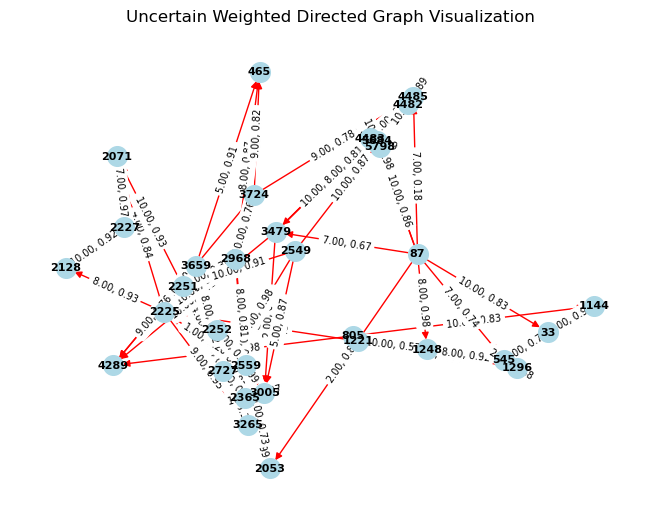

In [83]:
plot_graph_v2(ObsWikiVote06)

In [46]:
beta = 0.1

ObsWikiVote01 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [ObsWikiVote01[u][v]['probability'] for u, v in ObsWikiVote01.edges()]
weights = [ObsWikiVote01[u][v]['weight'] for u, v in ObsWikiVote01.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(ObsWikiVote01))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", ObsWikiVote01.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", ObsWikiVote01.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(ObsWikiVote01))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(ObsWikiVote01))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


100%|██████████████████████████████████████████████████████████████████████████████| 7113/7113 [43:11<00:00,  2.74it/s]


Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là: 24.55960832530815
Số đỉnh trong đồ thị con của thuật toán obs  là: 762
Số cạnh trong đồ thị con của thuật toán obs  là: 37085
sum_probabilities 18714.42154388481
num_possible_edges 579882
Mật độ kì cạnh vọng của thuật toán obs  là: 0.03227280988870979
Xác xuất cạnh trung bình của thuật toán obs là: 0.5046358782225917
 trọng số cạnh trung bình của thuật toán obs là: 5.546797896723743
Độ lệch chuẩn của thuật toán obs: 0.28911587760930796


In [ ]:
nx.write_gexf(ObsWikiVote01, "ObsWikiVote01.gexf")


In [4]:
beta = 0.2
ObsWikiVote02 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [ObsWikiVote02[u][v]['probability'] for u, v in ObsWikiVote02.edges()]
weights = [ObsWikiVote02[u][v]['weight'] for u, v in ObsWikiVote02.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(ObsWikiVote02))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", ObsWikiVote02.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", ObsWikiVote02.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(ObsWikiVote02))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(ObsWikiVote02))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)

100%|██████████████████████████████████████████████████████████████████████████████| 7113/7113 [50:05<00:00,  2.37it/s]


Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là: 24.46116175592696
Số đỉnh trong đồ thị con của thuật toán obs  là: 766
Số cạnh trong đồ thị con của thuật toán obs  là: 37028
sum_probabilities 18737.24990504005
num_possible_edges 585990
Mật độ kì cạnh vọng của thuật toán obs  là: 0.03197537484434897
Xác xuất cạnh trung bình của thuật toán obs là: 0.5060292185654114
 trọng số cạnh trung bình của thuật toán obs là: 0.5033128510313922
Độ lệch chuẩn của thuật toán obs: 0.28997723214426296


In [5]:
beta = 0.4

ObsWikiVote04 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [ObsWikiVote04[u][v]['probability'] for u, v in ObsWikiVote04.edges()]
weights = [ObsWikiVote04[u][v]['weight'] for u, v in ObsWikiVote04.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(ObsWikiVote04))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", ObsWikiVote04.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", ObsWikiVote04.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(ObsWikiVote04))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(ObsWikiVote04))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


100%|██████████████████████████████████████████████████████████████████████████████| 7113/7113 [45:11<00:00,  2.62it/s]


Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là: 22.385075464632674
Số đỉnh trong đồ thị con của thuật toán obs  là: 614
Số cạnh trong đồ thị con của thuật toán obs  là: 26320
sum_probabilities 13744.436335284463
num_possible_edges 376382
Mật độ kì cạnh vọng của thuật toán obs  là: 0.03651725198145624
Xác xuất cạnh trung bình của thuật toán obs là: 0.5222050279363398
 trọng số cạnh trung bình của thuật toán obs là: 0.5024641921060727
Độ lệch chuẩn của thuật toán obs: 0.289342031481842


In [6]:
beta = 0.6

ObsWikiVote06 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [ObsWikiVote06[u][v]['probability'] for u, v in ObsWikiVote06.edges()]
weights = [ObsWikiVote06[u][v]['weight'] for u, v in ObsWikiVote06.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(ObsWikiVote06))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", ObsWikiVote06.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", ObsWikiVote06.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(ObsWikiVote06))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(ObsWikiVote06))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


 22%|█████████████████                                                             | 1557/7113 [04:48<17:10,  5.39it/s]


KeyboardInterrupt: 

In [7]:
beta = 0.8

ObsWikiVote08 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [ObsWikiVote08[u][v]['probability'] for u, v in ObsWikiVote08.edges()]
weights = [ObsWikiVote08[u][v]['weight'] for u, v in ObsWikiVote08.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(ObsWikiVote08))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", ObsWikiVote08.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", ObsWikiVote08.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(ObsWikiVote08))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(ObsWikiVote08))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


100%|██████████████████████████████████████████████████████████████████████████████| 7113/7113 [07:28<00:00, 15.87it/s]

Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là: 0.576373392914729
Số đỉnh trong đồ thị con của thuật toán obs  là: 32
Số cạnh trong đồ thị con của thuật toán obs  là: 19
sum_probabilities 18.443948573271328
num_possible_edges 992
Mật độ kì cạnh vọng của thuật toán obs  là: 0.018592690094023517
Xác xuất cạnh trung bình của thuật toán obs là: 0.970734135435333
 trọng số cạnh trung bình của thuật toán obs là: 0.8766310236385282
Độ lệch chuẩn của thuật toán obs: 0.026186013558480437


In [89]:
nx.write_gexf(ObsWikiVote02, "ObsWikiVote02.gexf")
nx.write_gexf(ObsWikiVote04, "ObsWikiVote04.gexf")
nx.write_gexf(ObsWikiVote08, "ObsWikiVote08.gexf")


# Đối với đồ thị p2p-Gnutella08

In [66]:
random.seed(1)
# Initialize a directed graph
G = nx.DiGraph()

# Assuming your data is stored in a file called 'email-Eu-core.txt'
# and the data starts from a specific line after the header.
# Adjust the path to where you have stored your file.
with open('p2p-Gnutella08.txt', 'r') as file:
    for line in file:
        # Skip header lines or process them differently if needed
        if line.startswith('#'):
            continue
        
        # Split the line into source and target nodes
        source, target = map(int, line.split())
        # Assign a random probability to each edge
        probability = random.random()  # Generate a random probability between 0 and 1
        # Assign a random weight to each edge (for example, between 1 and 10)
        weight = random.random()
        G.add_edge(source, target, probability=probability, weight=weight)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())




# Optional: Print some edges with their attributes to verify
# for u, v, data in G.edges(data=True):
#     print(f"Edge ({u}, {v}) - Probability: {data['probability']}, Weight: {data['weight']}")


# Lấy các giá trị xác suất từ các cạnh
probabilities = [G[u][v]['probability'] for u, v in G.edges()]
weights = [G[u][v]['weight'] for u, v in G.edges()]
# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)


# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)

    
print("Giá trị cạnh trung bình của đồ thị protein579138:", mean_probability)
print("Độ lệch chuẩn của của  đồ thị protein579138:", std_deviation)
print("Trọng số cạnh trung bình của đồ thị là:",mean_weight)





Number of nodes: 6301
Number of edges: 20777
Giá trị cạnh trung bình của đồ thị protein579138: 0.5004933345397413
Độ lệch chuẩn của của  đồ thị protein579138: 0.2896557323372045
Trọng số cạnh trung bình của đồ thị là: 0.4994369331921513


In [67]:
beta = 0.6

p2pGnutella06 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [p2pGnutella06[u][v]['probability'] for u, v in p2pGnutella06.edges()]
weights = [p2pGnutella06[u][v]['weight'] for u, v in p2pGnutella06.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(p2pGnutella06))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", p2pGnutella06.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", p2pGnutella06.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(p2pGnutella06))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(p2pGnutella06))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


100%|██████████████████████████████████████████████████████████████████████████████| 6299/6299 [06:47<00:00, 15.47it/s]

Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là: 0.927036378249573
Số đỉnh trong đồ thị con của thuật toán obs  là: 4
Số cạnh trong đồ thị con của thuật toán obs  là: 4
sum_probabilities 3.708145512998292
num_possible_edges 12
Mật độ kì cạnh vọng của thuật toán obs  là: 0.309012126083191
Xác xuất cạnh trung bình của thuật toán obs là: 0.927036378249573
 trọng số cạnh trung bình của thuật toán obs là: 0.678131428379578
Độ lệch chuẩn của thuật toán obs: 0.055061133437259706


In [ ]:
beta = 0.1

p2pGnutella08 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [p2pGnutella08[u][v]['probability'] for u, v in p2pGnutella08.edges()]
weights = [p2pGnutella08[u][v]['weight'] for u, v in p2pGnutella08.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(p2pGnutella08))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", p2pGnutella08.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", p2pGnutella08.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(p2pGnutella08))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(p2pGnutella08))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


 75%|██████████████████████████████████████████████████████████▎                   | 4710/6299 [11:40<01:19, 20.04it/s]

In [ ]:
beta = 0.4

p2pGnutella04 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [p2pGnutella04[u][v]['probability'] for u, v in p2pGnutella04.edges()]
weights = [p2pGnutella04[u][v]['weight'] for u, v in p2pGnutella04.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(p2pGnutella04))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", p2pGnutella04.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", p2pGnutella04.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(p2pGnutella04))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(p2pGnutella04))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


In [ ]:
beta = 0.8

p2pGnutella08 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [p2pGnutella08[u][v]['probability'] for u, v in p2pGnutella08.edges()]
weights = [p2pGnutella08[u][v]['weight'] for u, v in p2pGnutella08.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(p2pGnutella08))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", p2pGnutella08.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", p2pGnutella08.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(p2pGnutella08))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(p2pGnutella08))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


# Đồ thị 579138.protein

In [41]:
random.seed(9)

# Đọc dữ liệu từ tệp TXT
file_path = '579138.protein.links.full.v12.0.txt/579138.protein.links.full.v12.0.txt'
data = pd.read_csv(file_path, sep=' ')

# Khởi tạo đồ thị có hướng
G = nx.DiGraph()

# Thêm các cạnh với trọng số và xác suất
for _, row in data.iterrows():
    protein1 = row['protein1']
    protein2 = row['protein2']
    combined_score = row['combined_score']
    
    # Giả sử xác suất được tính dựa trên combined_score
    probability = combined_score / 1000.0  # Điều chỉnh hệ số nếu cần thiết

     # Định hướng cạnh dựa trên một quy tắc ngẫu nhiên
    if random.choice([True, False]):
        G.add_edge(protein1, protein2, probability= probability, weight=random.random())
#     else:
#         G.add_edge(protein2, protein1, probability= probability, weight=random.randint(1, 10))

# # Hàm vẽ đồ thị
# def plot_graph(G):
#     pos = nx.spring_layout(G)  # Tạo bố cục cho đồ thị

#     # Lấy thuộc tính xác suất và trọng số của các cạnh
#     edge_probabilities = nx.get_edge_attributes(G, 'probability')
#     edge_weights = nx.get_edge_attributes(G, 'weight')

#     # Kết hợp xác suất và trọng số vào nhãn cạnh
#     edge_labels = {edge: f"{edge_weights[edge]:.2f}, {edge_probabilities[edge]:.2f}" for edge in G.edges()}

#     # Vẽ đồ thị
#     nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='red', node_size=500, font_size=8, font_weight='bold')
#     nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)  # Hiển thị nhãn của các cạnh

#     plt.title('Uncertain Weighted Directed Graph Visualization')
#     plt.show()

# # Gọi hàm để vẽ đồ thị
# plot_graph(G)

# # In các cạnh của đồ thị có hướng
# print("Edges in directed graph:")
# for edge in G.edges(data=True):
#     print(edge)
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 1672
Number of edges: 106758


In [42]:

# Lấy các giá trị xác suất từ các cạnh
probabilities = [G[u][v]['probability'] for u, v in G.edges()]
weights = [G[u][v]['weight'] for u, v in G.edges()]
# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)


# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
do_lech_chuan_trong_so = np.std(weights)

    
print("Giá trị cạnh trung bình của đồ thị protein579138:", mean_probability)
print("Độ lệch chuẩn của của  đồ thị protein579138:", std_deviation)
print("Độ lệch chuẩn trọng số của đồ thị con được tạo ra bởi thuật toán uds là:", do_lech_chuan_trong_so)
print("Trọng số cạnh trung bình của đồ thị là:",mean_weight)




Giá trị cạnh trung bình của đồ thị protein579138: 0.32007921654583266
Độ lệch chuẩn của của  đồ thị protein579138: 0.21746639681189547
Độ lệch chuẩn trọng số của đồ thị con được tạo ra bởi thuật toán uds là: 0.28810709549597074
Trọng số cạnh trung bình của đồ thị là: 0.49961743613897386


In [40]:
beta = 0.1

Obs579138Protein01 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs579138Protein01[u][v]['probability'] for u, v in Obs579138Protein01.edges()]
weights = [Obs579138Protein01[u][v]['weight'] for u, v in Obs579138Protein01.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs579138Protein01))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein01.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein01.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs579138Protein01))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs579138Protein01))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


100%|██████████████████████████████████████████████████████████████████████████████| 1668/1668 [06:47<00:00,  4.09it/s]


Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là: 41.351226434365635
Số đỉnh trong đồ thị con của thuật toán obs  là: 811
Số cạnh trong đồ thị con của thuật toán obs  là: 66922
sum_probabilities 33535.84463827053
num_possible_edges 656910
Mật độ kì cạnh vọng của thuật toán obs  là: 0.051050896832550166
Xác xuất cạnh trung bình của thuật toán obs là: 0.501118386155084
 trọng số cạnh trung bình của thuật toán obs là: 0.5021173431388396
Độ lệch chuẩn của thuật toán obs: 0.2883559779273041


In [43]:
beta = 0.2

Obs579138Protein02 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs579138Protein02[u][v]['probability'] for u, v in Obs579138Protein02.edges()]
weights = [Obs579138Protein02[u][v]['weight'] for u, v in Obs579138Protein02.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
# print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs579138Protein02))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein02.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein02.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs579138Protein02))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs579138Protein02))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


Processing: 1672node [08:44,  3.19node/s]                                                                              

Số đỉnh trong đồ thị con của thuật toán obs  là: 82
Số cạnh trong đồ thị con của thuật toán obs  là: 3173
sum_probabilities 2828.197000000003
num_possible_edges 6642
Mật độ kì cạnh vọng của thuật toán obs  là: 0.425805028605842
Xác xuất cạnh trung bình của thuật toán obs là: 0.8913321777497645
 trọng số cạnh trung bình của thuật toán obs là: 0.5087647350836987
Độ lệch chuẩn của thuật toán obs: 0.18578439757974635


In [44]:
beta = 0.3

Obs579138Protein02 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs579138Protein02[u][v]['probability'] for u, v in Obs579138Protein02.edges()]
weights = [Obs579138Protein02[u][v]['weight'] for u, v in Obs579138Protein02.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
# print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs579138Protein02))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein02.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein02.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs579138Protein02))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs579138Protein02))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


Processing:   2%|█▎                                                                | 34/1670 [00:46<37:38,  1.38s/node]


KeyboardInterrupt: 

In [42]:
beta = 0.4

Obs579138Protein04 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs579138Protein04[u][v]['probability'] for u, v in Obs579138Protein04.edges()]
weights = [Obs579138Protein04[u][v]['weight'] for u, v in Obs579138Protein04.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs579138Protein04))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein04.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein04.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs579138Protein04))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs579138Protein04))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


100%|██████████████████████████████████████████████████████████████████████████████| 1668/1668 [05:05<00:00,  5.46it/s]


Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là: 39.866268914200546
Số đỉnh trong đồ thị con của thuật toán obs  là: 785
Số cạnh trong đồ thị con của thuật toán obs  là: 61776
sum_probabilities 31295.021097647426
num_possible_edges 615440
Mật độ kì cạnh vọng của thuật toán obs  là: 0.05084983279872518
Xác xuất cạnh trung bình của thuật toán obs là: 0.5065886606068283
 trọng số cạnh trung bình của thuật toán obs là: 0.5025474884626338
Độ lệch chuẩn của thuật toán obs: 0.2882540483386092


In [37]:
beta = 0.6

Obs579138Protein06 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs579138Protein06[u][v]['probability'] for u, v in Obs579138Protein06.edges()]
weights = [Obs579138Protein06[u][v]['weight'] for u, v in Obs579138Protein06.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs579138Protein06))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein06.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein06.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs579138Protein06))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs579138Protein06))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)

Processing: 1672node [07:00,  3.97node/s]                                                                              

Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là: 33.064783783783845
Số đỉnh trong đồ thị con của thuật toán obs  là: 74
Số cạnh trong đồ thị con của thuật toán obs  là: 2639
sum_probabilities 2446.7940000000044
num_possible_edges 5402
Mật độ kì cạnh vọng của thuật toán obs  là: 0.4529422436134773
Xác xuất cạnh trung bình của thuật toán obs là: 0.9271671087533173
 trọng số cạnh trung bình của thuật toán obs là: 0.4984959101911617
Độ lệch chuẩn của thuật toán obs: 0.14722592252769304


In [44]:
beta = 0.8

Obs579138Protein08 = greedy_average_surplus_degree(G,beta)
# Lấy các giá trị xác suất từ các cạnh
probabilities = [Obs579138Protein08[u][v]['probability'] for u, v in Obs579138Protein08.edges()]
weights = [Obs579138Protein08[u][v]['weight'] for u, v in Obs579138Protein08.edges()]

# Tính giá trị trung bình
mean_probability = np.mean(probabilities)
mean_weight = np.mean(weights)

# Tính độ lệch chuẩn
std_deviation = np.std(probabilities)
print("Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là:", expected_density(Obs579138Protein08))
print("Số đỉnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein08.number_of_nodes())
print("Số cạnh trong đồ thị con của thuật toán obs  là:", Obs579138Protein08.number_of_edges())
print("Mật độ kì cạnh vọng của thuật toán obs  là:",calculate_edge_density(Obs579138Protein08))
print("Xác xuất cạnh trung bình của thuật toán obs là:",average_edge_probability(Obs579138Protein08))
print(" trọng số cạnh trung bình của thuật toán obs là:",mean_weight)
print("Độ lệch chuẩn của thuật toán obs:", std_deviation)


100%|██████████████████████████████████████████████████████████████████████████████| 1668/1668 [02:13<00:00, 12.52it/s]

Mật độ kì vọng của đồ thị con do thuật toán obs sinh ra là: 0.9806890668278485
Số đỉnh trong đồ thị con của thuật toán obs  là: 2
Số cạnh trong đồ thị con của thuật toán obs  là: 2
sum_probabilities 1.961378133655697
num_possible_edges 2
Mật độ kì cạnh vọng của thuật toán obs  là: 0.9806890668278485
Xác xuất cạnh trung bình của thuật toán obs là: 0.9806890668278485
 trọng số cạnh trung bình của thuật toán obs là: 0.6524858577913011
Độ lệch chuẩn của thuật toán obs: 0.0034935599831801833
